In [1]:
import random

import pandas as pd
import numpy as np

from pyspark import SparkConf
from pyspark.sql import SparkSession

from replay.session_handler import State
from simulator.utils import pandas_to_spark

SPARK_LOCAL_DIR = '/data/home/anthony/tmp'
CHECKPOINT_DIR = '/data/home/anthony/tmp/checkpoints'

spark = SparkSession.builder\
    .appName('simulator')\
    .master('local[4]')\
    .config('spark.sql.shuffle.partitions', '4')\
    .config('spark.default.parallelism', '4')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '4g')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)

np.random.seed(1234)

users_df = pd.DataFrame(data=np.random.normal(1, 1, size=(10000, 35)), columns=[f'user_attr_{i}' for i in range(35)]) 
items_df = pd.DataFrame(data=np.random.normal(-1, 1, size=(2000, 35)), columns=[f'item_attr_{i}' for i in range(35)]) 
items_df.loc[random.sample(range(2000), 1000)] = np.random.normal(1, 1, size=(1000, 35))
users_df['user_id'] = np.arange(len(users_df))
items_df['item_id'] = np.arange(len(items_df))
history_df_all = pd.DataFrame()
history_df_all['user_id'] = np.random.randint(0, 10000, size=33000)
history_df_all['item_id'] = np.random.randint(0, 2000, size=33000)
history_df_all['relevance'] = 0

users_matrix = users_df.values[history_df_all.values[:, 0], :-1]
items_matrix = items_df.values[history_df_all.values[:, 1], :-1]
dot = np.sum(users_matrix * items_matrix, axis=1)
history_df_all['relevance'] = np.where(dot >= 0.5, 1, 0)
history_df_all = history_df_all.drop_duplicates(subset=['user_id', 'item_id'], ignore_index=True)

history_df_train = history_df_all.iloc[:30000]
history_df_val = history_df_all.iloc[30000:]

users_df = pandas_to_spark(users_df)
items_df = pandas_to_spark(items_df)
history_df_train = pandas_to_spark(history_df_train)
history_df_val = pandas_to_spark(history_df_val)

/data/home/anthony/.conda/envs/simulator/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
22/10/25 13:16:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/25 13:16:52 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/10/25 13:16:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/25 13:16:52 WARN Utils: Service 'SparkUI' could not bind on port 4041. 

## Divide users into strats

In [2]:
import pyspark.sql.functions as sf


## Divide users by half for demostration purposes
users_cluster_1_df = users_df.filter(sf.col('user_id') < 5000)
users_cluster_2_df = users_df.filter(sf.col('user_id') >= 5000)

## Обучение генераторов

In [3]:
import warnings
warnings.filterwarnings("ignore")

from simulator.modules import RealDataGenerator, SDVDataGenerator, CompositeGenerator
from simulator.modules import evaluate_synthetic

generator_1 = SDVDataGenerator(
    label='synth_strat_1',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)
generator_2 = SDVDataGenerator(
    label='synth_strat_2',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

items_generator = RealDataGenerator(label='items_real', seed=1234)

generator_1.fit(users_cluster_1_df.drop('user_id'))
generator_2.fit(users_cluster_2_df.drop('user_id'))
items_generator.fit(items_df)

for g, d in zip([generator_1, generator_2], [users_cluster_1_df, users_cluster_2_df]):
    print(g.getLabel(), evaluate_synthetic(g.generate(d.count()).drop('user_id'), d.drop('user_id')))

users_com_generator = CompositeGenerator(
    generators=[generator_1, generator_2],
    label='users_composite',
    weights=[0.5, 0.5]
)
users_com_generator.generate(10000)

22/10/25 13:17:02 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


synth_strat_1 {'LogisticDetection': 1.0, 'SVCDetection': 0.8793778867074163, 'KSTest': 0.9855257142857143, 'ContinuousKLDivergence': 0.9671574151768041}
synth_strat_2 {'LogisticDetection': 1.0, 'SVCDetection': 0.8765426150711384, 'KSTest': 0.9846000000000001, 'ContinuousKLDivergence': 0.9670461996009401}


## Simulator initialization

In [4]:
from simulator.modules import Simulator

sim = Simulator(
    user_gen=users_com_generator,
    item_gen=items_generator,
    data_dir=f'{CHECKPOINT_DIR}/pipeline',
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark
)

## Response function

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import PipelineModel
from simulator.response import CosineSimilatiry, BernoulliResponse, NoiseResponse, ParametricResponseFunction


va_users = VectorAssembler(
    inputCols=users_df.columns[:-1],
    outputCol='features_usr'
)

va_items = VectorAssembler(
    inputCols=items_df.columns[:-1],
    outputCol='features_itm'
)

cos_sim = CosineSimilatiry(
    inputCols=["features_usr", "features_itm"],
    outputCol="cosine_proba"
)

noise_resp = NoiseResponse(mu=0.5, sigma=0.2, outputCol='noise_proba', seed=1234)

resp_func = ParametricResponseFunction(
    inputCols=['cosine_proba', 'noise_proba'],
    outputCol='proba',
    weights=[1.0, 0.0]
)
br = BernoulliResponse(inputCol='proba', outputCol='response')

cos_sim_model = PipelineModel(
    stages=[
        va_users,
        va_items,
        cos_sim,
        noise_resp,
        resp_func,
        br
    ]
)

In [6]:
from simulator.modules import EvaluateMetrics

test_df = history_df_train.join(users_df, 'user_id', 'left')\
                          .join(items_df, 'item_id', 'left')

lr_eval = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='proba',
    labelCol='relevance',
    mllib_metrics=['areaUnderROC', 'areaUnderPR']
)
lr_eval(cos_sim_model.transform(test_df))

{'areaUnderROC': 1.0, 'areaUnderPR': 0.9999995429286047}

## Recommendation algorithm training

In [7]:
from replay.data_preparator import Indexer

indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=users_com_generator.sample(1.0), items=items_df)

from ucb import UCB

model = UCB(sample=True)
model.fit(log=indexer.transform(history_df_train.limit(1)))

In [8]:
from simulator.modules import EvaluateMetrics
from replay.metrics import NDCG, Precision, Recall

evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10}
)

In [9]:
import time
from replay.utils import get_top_k_recs

metrics = []
for i in range(50):
    iter_time = time.time()
    ## sample a bunch of users
    users = sim.sample_users(0.02).cache()

    log = sim.get_log(users)
    if log is None:
        log = history_df_train.limit(1)
    log = log.cache()

    recs = model.predict(
        log=indexer.transform(log),
        k=10,
        users=indexer.transform(users),
        items=indexer.transform(items_df)
    )
    recs = indexer.inverse_transform(recs).cache()

    ## simulate responses on recommended items
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=users,
        item_features=items_df,
        action_models=cos_sim_model
    ).select('user_id', 'item_id', 'relevance', 'response').cache()

    ## update log with simulated responses
    sim.update_log(true_resp, iteration=i)

    ## calculate metrics
    metrics.append(evaluator(true_resp))

    ## refit recommendation model
    model._clear_cache()
    train_log = sim.log.cache()
    model.fit(
        log=indexer.transform(
            train_log.select('user_id', 'item_id', 'response')\
                     .withColumnRenamed('response', 'relevance')
        )
    )

    users.unpersist()
    # pairs.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    train_log.unpersist()

    print(f'Iteration {i} finished in {time.time() - iter_time} sec.')

22/10/25 13:19:39 WARN DAGScheduler: Broadcasting large task binary with size 1196.9 KiB
22/10/25 13:19:42 WARN DAGScheduler: Broadcasting large task binary with size 1037.9 KiB
22/10/25 13:19:42 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB
22/10/25 13:19:42 WARN DAGScheduler: Broadcasting large task binary with size 1045.7 KiB
22/10/25 13:19:43 WARN DAGScheduler: Broadcasting large task binary with size 1071.4 KiB


Iteration 0 finished in 16.953267097473145 sec.


22/10/25 13:19:53 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:19:55 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:19:55 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:19:55 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:19:55 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 1 finished in 11.85647702217102 sec.


22/10/25 13:20:05 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:20:06 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:20:06 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:20:07 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:20:07 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 2 finished in 11.796584129333496 sec.


22/10/25 13:20:18 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:20:19 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:20:19 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:20:19 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:20:19 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 3 finished in 12.6285240650177 sec.


22/10/25 13:20:30 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 4 finished in 11.720694303512573 sec.


22/10/25 13:20:41 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:20:42 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:20:42 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:20:43 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:20:43 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 5 finished in 11.29584002494812 sec.


22/10/25 13:20:53 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:20:54 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:20:54 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:20:54 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:20:54 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 6 finished in 11.798566341400146 sec.


22/10/25 13:21:05 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:21:06 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:21:06 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:21:06 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:21:07 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 7 finished in 12.18830156326294 sec.


22/10/25 13:21:17 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:21:18 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:21:18 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:21:18 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:21:19 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 8 finished in 12.037229061126709 sec.


22/10/25 13:21:29 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:21:31 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:21:31 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 9 finished in 12.373937606811523 sec.


22/10/25 13:21:42 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 10 finished in 12.612672090530396 sec.


22/10/25 13:21:54 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:21:56 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 11 finished in 12.439698219299316 sec.


22/10/25 13:22:06 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:22:07 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:22:07 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:22:08 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:22:08 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 12 finished in 12.158002376556396 sec.


22/10/25 13:22:19 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:22:20 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:22:20 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:22:20 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:22:20 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 13 finished in 12.350621938705444 sec.


22/10/25 13:22:31 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:22:32 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:22:32 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:22:33 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:22:33 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 14 finished in 12.585139274597168 sec.


22/10/25 13:22:43 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:22:45 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:22:45 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:22:45 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:22:45 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 15 finished in 12.140209913253784 sec.


22/10/25 13:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 16 finished in 11.597395658493042 sec.


22/10/25 13:23:08 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:23:09 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:23:09 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:23:09 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:23:09 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 17 finished in 12.406867742538452 sec.


22/10/25 13:23:20 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:23:21 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:23:21 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:23:21 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:23:21 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 18 finished in 12.409728765487671 sec.


22/10/25 13:23:32 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:23:33 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:23:33 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:23:33 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:23:33 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 19 finished in 11.923715353012085 sec.


22/10/25 13:23:44 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 20 finished in 12.186859607696533 sec.


22/10/25 13:23:56 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:23:58 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 21 finished in 12.111578702926636 sec.


22/10/25 13:24:08 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:24:09 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:24:09 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:24:10 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:24:10 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 22 finished in 12.432615995407104 sec.


22/10/25 13:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:24:21 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:24:21 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 23 finished in 11.884602069854736 sec.


22/10/25 13:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:24:33 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:24:34 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:24:34 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 24 finished in 11.6283118724823 sec.


22/10/25 13:24:44 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:24:45 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:24:45 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:24:45 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:24:45 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 25 finished in 11.67641830444336 sec.


22/10/25 13:24:56 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:24:57 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:24:57 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:24:57 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:24:57 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 26 finished in 11.899410009384155 sec.


22/10/25 13:25:07 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 27 finished in 11.604933261871338 sec.


22/10/25 13:25:19 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:25:20 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:25:20 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:25:21 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:25:21 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 28 finished in 12.192487001419067 sec.


22/10/25 13:25:31 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:25:32 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:25:32 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:25:33 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:25:33 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 29 finished in 11.85927677154541 sec.


22/10/25 13:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:25:44 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:25:44 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:25:44 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:25:45 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 30 finished in 11.9087393283844 sec.


22/10/25 13:25:55 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:25:56 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:25:57 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 31 finished in 12.192616701126099 sec.


22/10/25 13:26:08 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:26:09 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:26:09 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:26:09 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:26:09 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 32 finished in 12.949300050735474 sec.


22/10/25 13:26:21 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:26:22 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:26:22 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:26:22 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:26:22 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 33 finished in 12.624414205551147 sec.


22/10/25 13:26:33 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:26:34 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:26:34 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:26:35 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:26:35 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 34 finished in 12.810271978378296 sec.


22/10/25 13:26:46 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:26:48 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 35 finished in 12.718792200088501 sec.


22/10/25 13:26:59 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1048.6 KiB
22/10/25 13:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 36 finished in 12.986697435379028 sec.


22/10/25 13:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:27:14 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 37 finished in 13.280146360397339 sec.


22/10/25 13:27:25 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:27:26 WARN DAGScheduler: Broadcasting large task binary with size 1048.6 KiB
22/10/25 13:27:26 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:27:27 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:27:27 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 38 finished in 13.126737594604492 sec.


22/10/25 13:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:27:40 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:27:40 WARN DAGScheduler: Broadcasting large task binary with size 1048.6 KiB
22/10/25 13:27:40 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:27:40 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 39 finished in 13.413279294967651 sec.


22/10/25 13:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:27:53 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:27:53 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:27:53 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:27:53 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 40 finished in 13.06849479675293 sec.


22/10/25 13:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:28:06 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:28:06 WARN DAGScheduler: Broadcasting large task binary with size 1048.6 KiB
22/10/25 13:28:06 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:28:06 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 41 finished in 12.799630880355835 sec.


22/10/25 13:28:17 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:28:19 WARN DAGScheduler: Broadcasting large task binary with size 1048.6 KiB
22/10/25 13:28:19 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:28:19 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:28:19 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 42 finished in 13.578798770904541 sec.


22/10/25 13:28:31 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:28:32 WARN DAGScheduler: Broadcasting large task binary with size 1048.6 KiB
22/10/25 13:28:32 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:28:32 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:28:32 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 43 finished in 13.003741025924683 sec.


22/10/25 13:28:44 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:28:45 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:28:45 WARN DAGScheduler: Broadcasting large task binary with size 1048.6 KiB
22/10/25 13:28:46 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:28:46 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 44 finished in 13.486114740371704 sec.


22/10/25 13:28:58 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:28:59 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:28:59 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:28:59 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:28:59 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 45 finished in 13.702731132507324 sec.


22/10/25 13:29:11 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:29:12 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:29:12 WARN DAGScheduler: Broadcasting large task binary with size 1048.6 KiB
22/10/25 13:29:13 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:29:13 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 46 finished in 13.267358303070068 sec.


22/10/25 13:29:25 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:29:26 WARN DAGScheduler: Broadcasting large task binary with size 1048.5 KiB
22/10/25 13:29:26 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:29:26 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:29:26 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 47 finished in 13.505533695220947 sec.


22/10/25 13:29:38 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:29:39 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:29:39 WARN DAGScheduler: Broadcasting large task binary with size 1048.6 KiB
22/10/25 13:29:39 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:29:40 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 48 finished in 13.393417835235596 sec.


22/10/25 13:29:52 WARN DAGScheduler: Broadcasting large task binary with size 1207.3 KiB
22/10/25 13:29:53 WARN DAGScheduler: Broadcasting large task binary with size 1048.2 KiB
22/10/25 13:29:53 WARN DAGScheduler: Broadcasting large task binary with size 1048.6 KiB
22/10/25 13:29:53 WARN DAGScheduler: Broadcasting large task binary with size 1056.3 KiB
22/10/25 13:29:53 WARN DAGScheduler: Broadcasting large task binary with size 1082.0 KiB


Iteration 49 finished in 13.94927430152893 sec.


(0.6, 1.01)

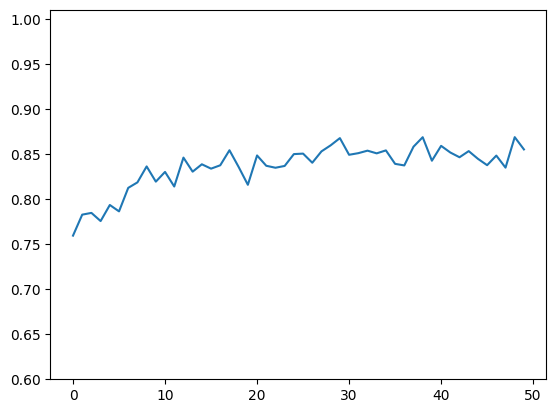

In [10]:
metrics_pdf = pd.DataFrame(metrics)

%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(metrics_pdf['NDCG@10'])
plt.ylim(0.6, 1.01)